# `numba` tests

This notebook documents and serves as a scratchpad for exploring `numba`-based acceleration on areal interpolation.

**NOTE** - To be removed/relocated once/if functionality is merged

In [23]:
import tobler.area_weighted.area_interpolate as ai
from tobler.area_weighted.area_interpolate import _area_tables_binning
from importlib import reload
import geopandas
from numba import njit
import numba

## Data setup

In [19]:
p = ("https://geographicdata.science/book/_downloads/"\
    "f2341ee89163afe06b42fc5d5ed38060/sandiego_tracts.gpkg")
tracts = geopandas.read_file(p)

p = ("https://geographicdata.science/book/_downloads/"\
     "d740a1069144baa1302b9561c3d31afe/sd_h3_grid.gpkg")
h3 = geopandas.read_file(p).to_crs(tracts.crs)

w, s, e, n = h3.total_bounds
tracts = tracts.cx[w:e, s:n]

<AxesSubplot:>

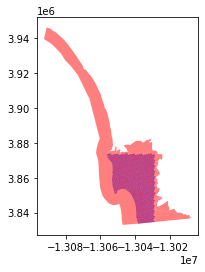

In [20]:
ax = h3.plot(alpha=0.5, color='b')
tracts.plot(ax=ax, alpha=0.5, color='r')

## Experiments

In [48]:
%timeit [set() for i in range(tracts.shape[0])]

37.8 µs ± 603 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [47]:
%timeit cross = _area_tables_binning(tracts, h3)

1.54 s ± 25.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
cross

<628x644 sparse matrix of type '<class 'numpy.float32'>'
	with 1912 stored elements in Dictionary Of Keys format>

---

In [26]:
@njit
def f(n):
    l = numba.typed.List()
    for i in range(n):
        l.append(set([1 for i in range(0)]))
    return l
f(3)

ListType[set(int64)]([set(), set(), set()])

In [39]:
@njit
def flc(n):
    l = numba.typed.List()
    s = set([1 for i in range(0)])
    for i in range(n):
        l.append(s)
    return l
f(3)

ListType[set(int64)]([set(), set(), set()])

In [40]:
@njit
def flc_p(n):
    l = numba.typed.List()
    s = set([1 for i in range(0)])
    for i in numba.prange(n):
        l.append(s)
    return l
f(3)

ListType[set(int64)]([set(), set(), set()])

In [49]:
n = 100000

In [50]:
%timeit flc_p(n)

3.66 ms ± 62.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [51]:
%timeit flc(n)

3.67 ms ± 54.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
%timeit f(n)

45.9 ms ± 614 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [53]:
%timeit [set() for i in range(n)]

24.1 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
